# Testing `Whirl2d` on Navier-Stokes solution with a body 

In [20]:
include(joinpath(Pkg.dir("whirl2d"), "src/Whirl2d.jl"))
import Whirl2d
import Whirl2d:@get
using PyPlot
@get Whirl2d (Systems, Grids, DualPatch, Bodies, TimeMarching, NavierStokes, Process);

### Create a body

#### Create a cylinder

In [21]:
bcyl = let Npts = 100  # total number of points on circle
            rad = 0.5   # radius of circle
            xcent = [0.0,0.0]  # initial centroid of circle
            ang = 0.0    # initial angle of circle
            Bodies.Circle(Npts,rad,xcent,ang)
end

Body: number of points = 100, reference point = (0.0,0.0), rotation matrix = [1.0 -0.0; 0.0 1.0]


#### Or create a plate

In [22]:
bplate = let Npts = 100  # number of points on each flat side of plate
        len = 1.0   # length of the plate
        thick = 0.023 # thickness
        λ = thick/len  # a parameter that controls the ratio of spacing of points on plate
        xcent = [0.0,0.0] # initial centroid of the body
        ang = -π/4  # initial orientation of the body
        Bodies.Plate(Npts,len,thick,λ,xcent,ang)
end

Body: number of points = 364, reference point = (0.0,0.0), rotation matrix = [0.707107 0.707107; -0.707107 0.707107]


### Create a domain with this body in it

In [23]:
dom = let
        xmin = [-1.0,-1.0] # minimum dimensions of domain
        xmax = [3.0,1.0]   # maximum dimensions of domain
        Systems.DualDomain(xmin,xmax)
end

# Add the body to the domain
dom = Systems.add_body(dom,bcyl)

Domain: xmin = [-1.0, -1.0], xmax = [3.0, 1.0]
number of bodies = 1
Body: number of points = 100, reference point = (0.0,0.0), rotation matrix = [1.0 -0.0; 0.0 1.0]



#### Add a filling dual grid to this domain
The boundaries of the domain coincide with the boundaries of the dual grid

In [24]:
Δx = 0.02
dom = Systems.add_grid(dom,Δx)

Domain: xmin = [-1.0, -1.0], xmax = [3.0, 1.0]
number of bodies = 1
Body: number of points = 100, reference point = (0.0,0.0), rotation matrix = [1.0 -0.0; 0.0 1.0]

Grid: number of cells = (200,100), Δx = 0.02, xmin = [-1.0, -1.0], xmax = [3.0, 1.0]



### Set the physical and time parameters

In [25]:
Re = 200
physparams = let U = [1.0,0.0]
    NavierStokes.set_freestream(U)
end
NavierStokes.set_Re!(physparams,Re)
Δt = min(0.5*Δx,Δx^2*Re)

α = Δt/(Re*Δx^2)
tparams = TimeMarching.TimeParams(Δt,TimeMarching.RK31())

params = (physparams,α)
tparams

Time step size 0.01

### Compute the grid and body operators
This fills in the LGF and integrating factor tables, computes the interpolation/regularization operators, computes the Schur complement operators and factorizes them, and defines the operators needed for calling the HERK

In [26]:
gops, ops = NavierStokes.set_operators_body!(dom,params);

Setting up LGF table
  3.319139 seconds (3.41 M allocations: 408.770 MiB, 2.10% gc time)
Setting up integrating factor table
  0.045158 seconds (2.96 k allocations: 1.964 MiB)
Setting up body-to-grid operator
  2.893713 seconds (1.99 M allocations: 576.609 MiB, 3.39% gc time)
Computing Schur complements and inverses
  1.969704 seconds (28.70 k allocations: 161.641 MiB, 1.70% gc time)
  0.861421 seconds (19.80 k allocations: 129.164 MiB, 2.68% gc time)


### Create an initial solution structure

In [27]:
s = NavierStokes.BodySoln(dom)
h = [s]

1-element Array{Whirl2d.ConstrainedSoln{Array{Float64,2},Array{Float64,2}},1}:
 Solution: t = 0.0


### Advance the solution

In [28]:
@time for i = 1:200
    s = TimeMarching.ifherk!(s,tparams,ops)
    push!(h,s)
end
s

LoadError: [91mMethodError: no method matching string(::Expr)
The applicable method may be too new: running in world age 2754, while current world is 24160.[0m
Closest candidates are:
  string(::Any...) at strings/io.jl:120 (method too new to be called from this world context.)
  string([91m::BigInt[39m) at gmp.jl:568 (method too new to be called from this world context.)
  string([91m::BigFloat[39m) at mpfr.jl:885 (method too new to be called from this world context.)
  ...[39m

### Evaluate the fields in the solution history

In [262]:
@time f = NavierStokes.evaluateFields.(h,dom.grid,gops);
t = map(x -> x.t, f);
ω = map(x -> x.ω, f);
ψ = map(x -> x.ψ, f);
ux = map(x -> x.ux, f);
uy = map(x -> x.uy, f);

  1.407435 seconds (11.51 k allocations: 435.903 MiB, 29.05% gc time)


### Evaluate and plot the force history

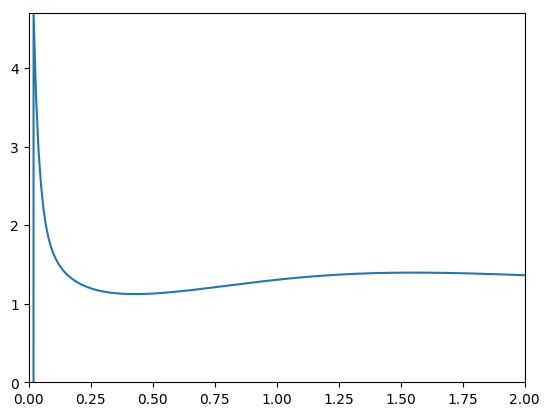

(0, 2.0000000000000013)

In [269]:
tforce, fx, fy = NavierStokes.force(h,dom.grid);
plot(tforce,2*fx)
ylim(0,maximum(2*fx))
xlim(0,tforce[end])

### Sample the solution at some point

In [263]:
spts = Process.SamplePoint(1.5,1.5)

Whirl2d.Process.SamplePoints([1.5], [1.5])

In [264]:
x = Grids.xfacex(dom.grid)
y = Grids.yfacex(dom.grid)
uxsamp = Process.sample(spts,ux,x,y)

1-element Array{Array{Float64,1},1}:
 [0.0, 0.0144011, 0.0147398, 0.0150096, 0.0152371, 0.0154388, 0.0156248, 0.0158013, 0.0159724, 0.0161409  …  0.0987671, 0.0992734, 0.0997759, 0.100274, 0.100769, 0.10126, 0.101746, 0.102228, 0.102706, 0.103179]

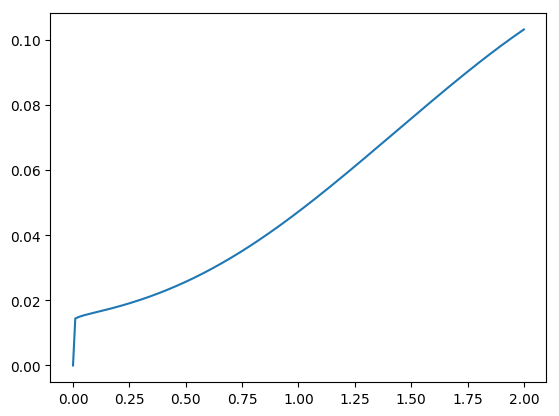

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x12f43cfd0>

In [265]:
plot(t,uxsamp[1])

### Plot the fields

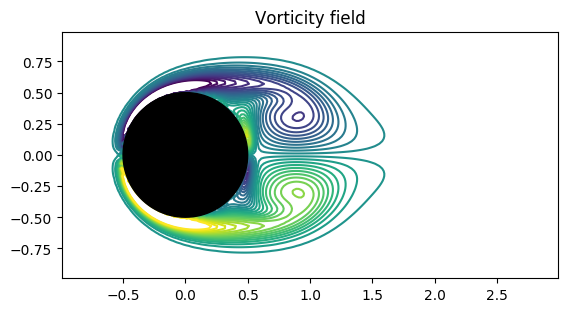

PyObject <matplotlib.text.Text object at 0x12f454a10>

In [266]:
x = Grids.xcell(dom.grid)
y = Grids.ycell(dom.grid)

contour(x,y,transpose(ω[end]),linspace(-10,10,30))
for j = 1:dom.nbody
    xpt = [dom.body[j].x[i][1] for i = 1:dom.body[j].N]
    ypt = [dom.body[j].x[i][2] for i = 1:dom.body[j].N]
    fill(xpt,ypt,color="k",zorder=2)
end
axis("scaled")
title("Vorticity field")

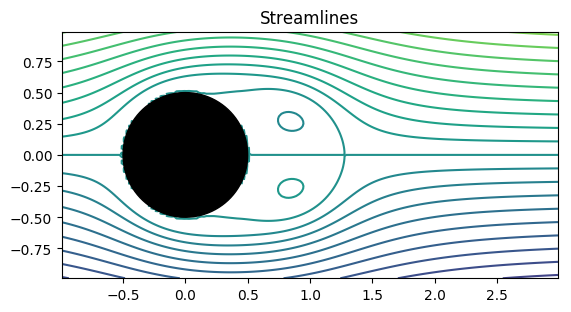

PyObject <matplotlib.text.Text object at 0x122b38350>

In [267]:
x = Grids.xcell(dom.grid)
y = Grids.ycell(dom.grid)
contour(x,y,y.+transpose(ψ[end]),linspace(-1.5,1.5,31))
for j = 1:dom.nbody
    xpt = [dom.body[j].x[i][1] for i = 1:dom.body[j].N]
    ypt = [dom.body[j].x[i][2] for i = 1:dom.body[j].N]
    fill(xpt,ypt,color="k",zorder=2)
end
axis("scaled")
title("Streamlines")

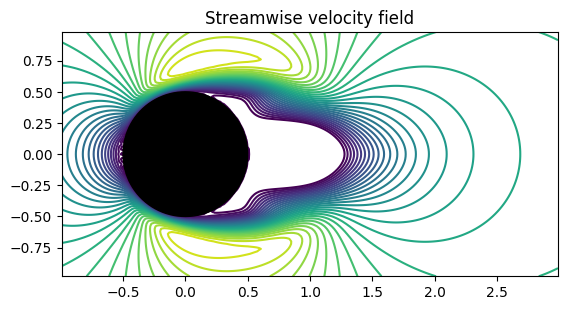

PyObject <matplotlib.text.Text object at 0x133a98250>

In [268]:
contour(Grids.xfacex(dom.grid),Grids.yfacex(dom.grid),transpose(ux[end]).+1,linspace(0,1.5,31))
for j = 1:dom.nbody
    xpt = [dom.body[j].x[i][1] for i = 1:dom.body[j].N]
    ypt = [dom.body[j].x[i][2] for i = 1:dom.body[j].N]
    fill(xpt,ypt,color="k",zorder=2)
end
axis("scaled")
title("Streamwise velocity field")